# Run interventions in loop with OpenABM 

In [ ]:
import sys
sys.path.insert(0,'./src/')
from pathlib import Path
import log, logging
from importlib import reload
import loop_abm

#logging
output_dir = "./output/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()

## Epidemic model

#### set parameters of the openABM foward simulation

In [ ]:
N=50000 #Number of individuals
T=100 #Total time of simulations
seed = 2 #random seed
n_seed_infection = 20 #number of patient zero

params_model = {
    "rng_seed" : seed,
    "end_time" : T,
    "n_total"  : N,
    "days_of_interactions" : T,
    "n_seed_infection" : n_seed_infection,
}

## Set testing and quarantine rules

In [ ]:
fraction_SM_obs = 0.5 #fraction of Symptomatic Mild tested positive
fraction_SS_obs = 1 #fraction of Symptomatic Severe tested positive
initial_steps = 12 #starting time of intervention
quarantine_HH = True #Households quarantine
test_HH = True #Tests the households when quarantined
adoption_fraction = 1 #app adoption (fraction)
num_test_random = 0 #number of random tests per day
num_test_algo = 250 #number of tests using by the ranker per day

## Choose the rankers algorithms class

In [13]:
from rankers import dotd_rank, tracing_rank, mean_field_rank, sib_rank
import sib


prob_seed = 1/N
prob_sus = 0.55
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1/N
fp_rate = 0.0
fn_rate = 0.0


dotd = dotd_rank.DotdRanker()

tracing = tracing_rank.TracingRanker(
                 tau=5,
                 lamb=0.014
)

MF = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = 1/30,
                lamb = 0.014
                )


winbp20prob0 = sib_rank.SibRanker(
                 params = sib.Params(
                                 prob_i = sib.Cached(sib.Scaled(sib.PDF(sib.Gamma(k=5.76, mu=0.96)), scale=0.25), T+1),
                                 prob_r = sib.Cached(sib.Gamma(k = 10, mu = 1/1.7452974337097158), T+1),
                                 pseed = pseed,
                                 psus = psus,
                                 fp_rate = fp_rate,
                                 fn_rate = fn_rate,
                                 pautoinf = pautoinf),
                 maxit0 = 20,
                 maxit1 = 20,
                 tol = 1e-3,
                 memory_decay = 1e-5,
                 window_length = 21,
                 tau=7
)


ress = {}


In [14]:
rankers = {
  #  "random" : dotd,
  #  "tracing": tracing,
   "MF" : MF,
  "winbp20prob0": winbp20prob0,

} 

### Set up figure

In [15]:
%matplotlib widget
import matplotlib.pyplot as plt
import plot_utils
import time

plots = plot_utils.plot_style(N, T)
save_path_fig = f"./output/plot_run_N_{N}_SM_{fraction_SM_obs}_test_{num_test_algo}_n_seed_infection_{n_seed_infection}_seed_{seed}.png"
fig, callback = plot_utils.plotgrid(rankers, plots, initial_steps, save_path=save_path_fig)
time.sleep(0.5)
fig.canvas

Canvas(header_visible=False, toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Bac…

In [16]:
import imp 
imp.reload(loop_abm)

for s in rankers:
    data = {"algo":s}
    loop_abm.loop_abm(
        params_model, 
        rankers[s], 
        seed=seed, 
        logger = logging.getLogger(f"iteration.{s}"), 
        data = data, 
        callback = callback,
        initial_steps = initial_steps, 
        num_test_random = num_test_random,
        num_test_algo = num_test_algo,
        fraction_SM_obs = fraction_SM_obs,
        fraction_SS_obs = fraction_SS_obs,
        quarantine_HH = quarantine_HH,
        test_HH = test_HH,
        adoption_fraction = adoption_fraction,
        fp_rate = fp_rate,
        fn_rate = fn_rate,
        name_file_res = s + f"_N_{N}_T_{T}_obs_{num_test_algo}_SM_obs_{fraction_SM_obs}_seed_{seed}"
    )
    ress[s] = data
    # saves a bit of memory: rankers[s] = {}

COVID19.model: INFO     Returning self.c_params into Model object, future updates to parameters not possible
COVID19.model: INFO     Started model creation
COVID19.model: INFO     Successfuly created model
COVID19.model: INFO     Started model creation
COVID19.model: INFO     Successfuly created model
iteration.MF: INFO     time:0
iteration.MF: INFO     number of unique contacts: 633242
iteration.MF: INFO     True  : (S,I,R): (49900.0, 100.0, 0.0)
iteration.MF: INFO     AUR_I : 0.503, prec(1% of 50001): 0.00, prec5%: 0.00
iteration.MF: INFO     SS: 0, SM: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 100 free as birds (+100)
iteration.MF: INFO     time:1
iteration.MF: INFO     number of unique contacts: 633158
iteration.MF: INFO     True  : (S,I,R): (49889.0, 111.0, 0.0)
iteration.MF: INFO     AUR_I : 0.513, prec(1% of 50001): 0.00, prec5%: 0.00
iter

faster end


iteration.MF: INFO     True  : (S,I,R): (46852.0, 393.0, 2755.0)
iteration.MF: INFO     AUR_I : nan, prec(1% of 45250): 0.00, prec5%: 0.00
iteration.MF: INFO     SS: 0, SM: 0, results test algo (S,I,R): (999,0,1), infected test random: 0/0
iteration.MF: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.MF: INFO     time:52
iteration.MF: INFO     number of unique contacts: 547792


faster end


iteration.MF: INFO     True  : (S,I,R): (46850.0, 354.0, 2796.0)
iteration.MF: INFO     AUR_I : nan, prec(1% of 45249): 0.00, prec5%: 0.00
iteration.MF: INFO     SS: 0, SM: 0, results test algo (S,I,R): (999,0,1), infected test random: 0/0
iteration.MF: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)
iteration.MF: INFO     time:53
iteration.MF: INFO     number of unique contacts: 546870


faster end


iteration.MF: INFO     True  : (S,I,R): (46846.0, 311.0, 2843.0)
iteration.MF: INFO     AUR_I : 0.548, prec(1% of 45248): 0.00, prec5%: 0.00
iteration.MF: INFO     SS: 0, SM: 0, results test algo (S,I,R): (1000,0,0), infected test random: 0/0
iteration.MF: INFO     false+: 0 (+0), false-: 0 (+0)
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (+1)
iteration.MF: INFO     time:54
iteration.MF: INFO     number of unique contacts: 547030


IndexError: index 10 is out of bounds for axis 0 with size 9

## Results
[see complete results in the output folder]

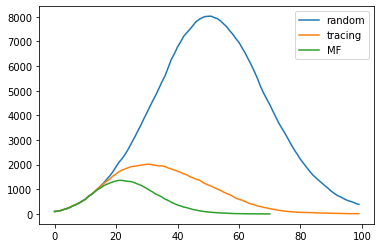

In [29]:
%matplotlib inline
to_plot = "I"
for s in ress.keys():
    plt.plot(ress[s][to_plot], label = s)
plt.legend()